# Week 7: Natural language processing

The exercises today are about extracting high-level knowledge from text. We're still a long way from computers being able to give us insight as deep as that which we can aquire from manually reading text, but some the tools that you will use today get us a long way in understanding useful things about unreadibly large amount of text in comparatively little time. In the exercises today you will:

* Create wordclouds
* Extract sentiment from text
* Construct a Bag of Words (BoW) matrix to represent how words are used about each faction in the Marvel dataset
* Perform a TD-IDF transform to understand which words are important to different characters

### Part 0: Clean text

The first task when working with text, is almost always to somehow clean the text. In our case, text is formatted
as Mediawiki markup, which has its quirks as you probably remember. So we need to clean this text and most of the
way we need to do it manually. But while this is a meaningful thing to learn to do, we don't want to take time away from the more important exercises
that come later in this exercise set. Therefore, you will find a helper function in this notebook that extracts and cleans the markup text of a Wikipedia page.  Remember to change the path so that it points to the data folder on your computer.

In [12]:
import re
import nltk

nltk.download('stopwords')

# Get a list of stopwords from nltk
stop_words = nltk.corpus.stopwords.words("english")
stop_words += ["ref", "name", "p"]

#print(stopwords)

def get_clean_text(filename, faction):
    def _isnum(w):
        try:
            int(w)
            return True
        except ValueError:
            return False
        
    # Load markup
    with open(f"../../data/{faction}/{filename}.txt") as fp:
        text = fp.read()
        
    # Remove table and external links
    markup_text = re.sub(r'\{\{[\s\S]*?\}\}', '', text)

    # Remove category links
    markup_text = re.sub(r'\[\[Category.+\]\]', '', markup_text)

    # Set words to lowercase and remove them if they are stop words
    words = [w.lower() for w in re.findall('\w+', markup_text) if w.lower() not in stop_words]

    # Remove numbers
    words = [w for w in words if not _isnum(w)]

    return words

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/thompsmj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
# Example
print(get_clean_text('Black Widow (Natasha Romanova)', 'heroes'))

['aliases', 'natalia', 'shostakova', 'natasha', 'romanoff', 'natalie', 'rushman', 'laura', 'matthers', 'mary', 'farrell', 'oktober', 'black', 'widow', 'yelena', 'belova', 'yelena', 'belova', 'partners', 'captain', 'america', 'br', 'bucky', 'barnes', 'winter', 'soldier', 'br', 'hawkeye', 'clint', 'barton', 'hawkeye', 'br', 'daredevil', 'marvel', 'comics', 'character', 'daredevil', 'supports', 'powers', 'expert', 'espionage', 'spy', 'military', 'tactics', 'tactician', 'master', 'martial', 'artist', 'hand', 'hand', 'combatant', 'slowed', 'aging', 'enhanced', 'immune', 'system', 'expert', 'marksman', 'mastery', 'various', 'weapons', 'skilled', 'hypnosis', 'hypnotist', 'equipment', 'via', 'gauntlets', 'grappling', 'hook', 'knock', 'gas', 'taser', 'explosives', 'tear', 'gas', 'pellets', 'radio', 'transmitter', 'cat', 'super', 'subcat', 'marvel', 'comics', 'hero', 'sortkey', 'black', 'widow', 'marvel', 'comics', 'black', 'widow', 'natalia', 'alianovna', 'natasha', 'romanova', 'russian', 'lang

### Part 1: Wordcloud

Although they probably offer more buzz than usefulness, wordclouds are a fun way to get quick insight into which words are used in a corpus of text. In this section you will generate some.  We start with an example generating a wordcloud for Iron Man.

> *Hint: You must install `wordcloud` with anaconda by typing into your console*
>
>        conda install -c conda-forge wordcloud
>
>*or*
>
>        pip install wordcloud

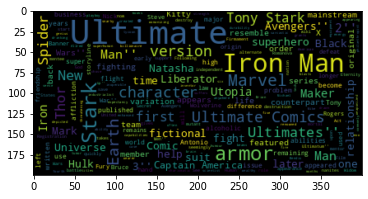

In [5]:
#wordcloud example
from wordcloud import WordCloud
import matplotlib.pylab as plt

ironman_text = get_clean_text("Iron Man (Ultimate Marvel character)", "heroes")

wc_ironman = WordCloud(max_font_size=40).generate(ironman_text)

plt.figure(figsize=(20, 8))

plt.subplot(1, 3, 1)
plt.imshow(wc_ironman, interpolation="bilinear")

>**Ex. 7.1.1**: Make a word cloud for each faction using the `wordcloud` module! Use `max_font_size=40` to make the wordcloud managable.

>* For each faction, concatenate all (cleaned) text about each character into one long string.
>* Make three plots with appropriate titles, so we can compare them visually.
>* You could choose to exclude all character names from the strings, that my give more interesting results. Not a requirement.
>* Comment on the differences you see.

In [ ]:
#Answer to 7.1.1

### Part 2: Sentiment analysis

Let's say you have an enormous amount of text, and you want to know something about its level of negativity, neutrality or positivity. Enter *Sentiment Analysis*. The point of this exercise is to extract the sentiment of text on your heroes, villains and ambiguous characters and figure out whether Wikipedia is biased towards writing in a certain tone towards a certain kind of characters.

>**Ex. 7.2.1**: Compute and visualize sentiment scores.
* Using the `VADER` algorithm supported in `nltk` (i.e. `from nltk.sentiment.vader import SentimentIntensityAnalyzer`), you can obtain three scores for a piece of text: it's inferred negativity, neutrality and positivity.
* Use `SentimentIntensityAnalyzer` to get these three scores for each character. Then, for each faction, make three distribution plots (e.g. histograms), that each show how negativity, neutrality and positivity are distributed, respectively. That's 9 plots in total.
* In each of these plots, report the mean of the distribution. Your plot should look [something along the lines of this](https://dhsvendsen.github.io/images/sentiment_histograms.png).
* Comment on your result. Does writing in Wikipedia seem biased to you?

### Part 3: Bag of Words matrix

Intuitively, "Bag of Words" means breaking up a document into words and throwing them into a bag. And that's very close to the truth! In week 5 you constructed a "team-affiliations" matrix which had a row for each character and a column for each team. If the character was on a given team there would be a one for that character row at that team column, if not there would be a zero. The BoW is the same, only now, rather than teams, your columns are individual words that a character's wikipage might contain, and the numbers represent how many times those words appear.
<img src="http://ulfaslak.com/computational_analysis_of_big_data/exer_figures/example_bow.png" width="400"/>
BoW's are pretty large and sparse (mostly contain zero's) matrices, but they are extremely useful because they allow us to use linear algebra to do things like PCA, classification, etc..

Here is a function for extracting a cleaned list of words from a string of text:

In [10]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

# Get list of stopwords and add a few
stop_words = set(stopwords.words('english'))

def get_clean_words(text, exclude_words=[]):
    """Given some text, return a list of clean words.
    
    Input
    -----
        text : str
        exclude_words : list
            Words to exclude (e.g. characters own name)
    
    Output
    ------
        words : list
        
    Example
    -------
        >>> my_text = get_clean_text('Iron Man', 'heroes')
        >>> my_words = get_clean_words(my_text, exclude_words=['Iron', 'Man'])
    """

    # Extarct words
    words = word_tokenize(text)
    
    # Add exclude words to words to give it same treatment
    words += exclude_words
    
    # Convert to lower case
    words = [w.lower() for w in words]
    
    # Clear punctuation
    table = str.maketrans('', '', string.punctuation)
    words = [w.translate(table) for w in words]
    
    # Seperate words and exclude words
    if len(exclude_words) > 0:
        exclude_words = words[-len(exclude_words):]
        words = words[:-len(exclude_words)]
    
    # Remove non-alphabetic words
    words = [w for w in words if w.isalpha()]
    
    # Remove stop words
    words = [w for w in words if not w in stop_words | set(exclude_words)]
    
    # Remove single letter words 
    words = [w for w in words if len(w) > 1]

    return words

>**Ex. 7.3.1**: Create a bag of words matrix that contains all your characters. Maintain also a target array, so you know whether a row corresponds to a hero, a villain or an ambiguous character. Also, **do not include words that only appear for one character**.
>*Hint: Since you already extracted lists of words for each faction in Ex. 7.1.1, you can use these to figure out what the total vocabulary of words used in your dataset is. You can "clean up" this vocabulary by a number of tricks. For example, there are tools for *stemming* words to remove grammar so that e.g. 'cat' and 'cats' both become 'cat', but that's all up to you whether you want to go that deep.*

1. How many different words are in your vocabulary/columns are in your matrix?

2. Print the 10 most used words, and the 10 least used words, along with their usage count.

3. Plot the distribution of how many times words are used. Scale it appropriately. What does this distribution look like?

> **Ex. 7.3.2.EXTRA**: Fit a PCA to your BoW matrix. Make a bar plot that shows the explained variance ratio of the first 20 components. What fraction of the total variance do the first 20 components explain?
>
> ***Earn up to 5 extra credit points for solving this problem.***

> **Ex. 7.3.3.EXTRA**: Create a classifier that predicts if a character is a hero or a villain (not ambiguous) from the words used on their page. Report its 10-fold cross validation accuracy. Comment on the result and compare this score with the one obtained in week 5 where you trained on team alliances.
>
> ***Earn up to 5 extra credits for solving this problem.***

### Part 4: TF-IDF

You didn't just make that BoW matrix to count simple things. We are interested in knowing how (or if) words are used differently across characters, and the best way to do that is to used something called a Term Frequency - Inverse Document Frequency (TF-IDF) transformation. You can read more about it [on Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), but the gist is that it reflects how important each word is to each document (a document in this case being a character) in the chorpus.

It works in two steps:
* (1 - TF) you normalize over the frequency of each word in each document, so that rows sum to 1. Every row is now a probability distribution that gives the "term frequency" in each document.
* (2 - IDF) you weigh the TF by the inverse document frequency, which measures how unique a word to specific documents. For example, the word "the" will be frequently used in every document (high TF) but we know it's not very special because it's used in all documents so the inverse document frequency is low, yielding a vanishing TF-IDF score for "the" in all documents.

>**Ex. 7.4.1**: Use any tool you like (you can do it manually, it's straight forward if you understand the method), to perform a TF-IDF transform on your BoW matrix from Ex. 7.3.1. The result should be a matrix of the same shape as the BoW, but with different values inside.



1. Explain what these values mean.

2. For the top three most written about characters in each class (so 9 in total), print out each of their 10 highest scoring words. Comment on any differences you observe in the type of words being used in different classes.

>**Ex. 7.4.2**: Install `umap-learn` and import it like `import umap`. UMAP is an algorithm for non-linear dimensionality reduction, that will allow you to visualize your data on a low-dimensional manifold. Using UMAP, transform the TF-IDF transformed BoW matrix into a 2-dimensional space. Plot the points in this space, colored by faction. Comment on the result.